In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random

In [2]:
def f(x):
    return x**2+2*x+4

In [3]:
f(3.0)

19.0

In [4]:
xs=np.arange(-5,5,0.25)

In [5]:
ys=f(xs)

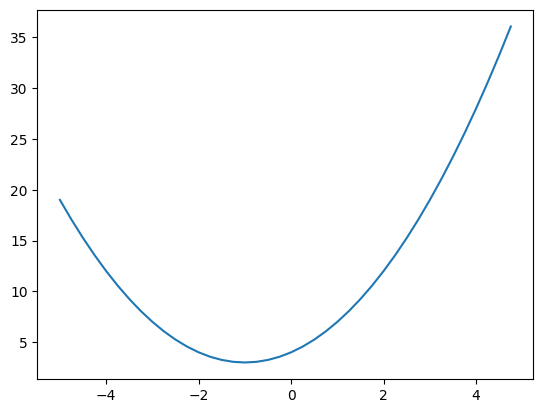

In [6]:
plt.plot(xs,ys)


In [7]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad=0.0 #Doesn't change the output. Has no effect.
        self._prev=set(_children)
        self._backward=lambda: None
        self._op=_op
        self.label=label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        other=other if isinstance(other, Value) else Value(other)
        out=Value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward=_backward #we store the function here.
        return out
        
    def __sub__(self, other):
        return self+(-other)
        
    def __mul__(self,other):
        other=other if isinstance(other, Value) else Value(other)
        out=Value(self.data*other.data,(self,other),'*')
        
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        return out
        
    def __rmul__(self, other):
        return self*other
        
    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,),f'**{other}')  
        def _backward():
            self.grad+=other*(self.data**(other-1))*out.grad #first part is the local derivative only. total is derivative wrt final o
        out._backward=_backward
        return out
        
    def __truediv__(self,other):
        return self*other**-1

    def __radd__(self,other):
        return self+other
        
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out
    def exp(self):
        x=self.data
        out=Value(math.exp(x), (self,),'exp')
        def _backward():
            self.grad+=out.data*out.grad 
        out._backward=_backward
        return out
    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo
        self.grad=1.0
        for node in reversed(topo):
            node._backward()
        

In [8]:
# inputs x1,x2
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')

w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

b=Value(6.88137358701995432,label='b')

x1w1=x1*w1; x1w1.label ='x1*w1'
x2w2=x2*w2; x2w2.label ='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n= x1w1x2w2+b; n.label='n'
o=n.tanh(); o.label='o'
o.backward()

In [9]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'})  # LR = left to right
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f| grad %.4f }" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # Connect n2 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


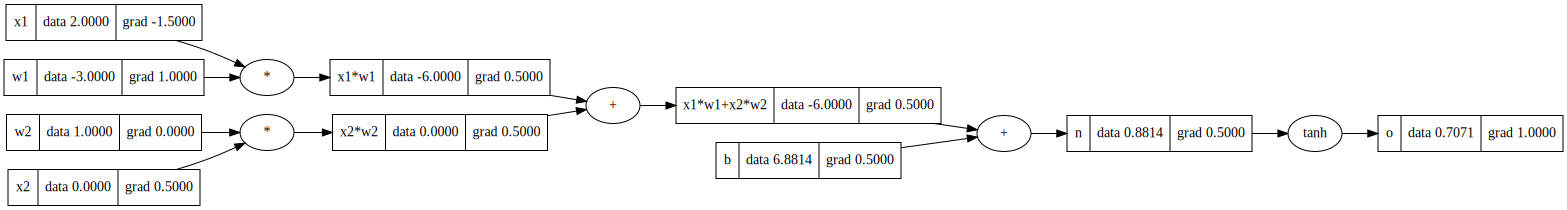

In [10]:
draw_dot(o) #grad represents the derivative of the output with respect to the element

In [11]:
#dL/de=-2=dL/dd*dd/de; d(c+e)/de or dc always 1 so dL/dd=dL/de. loccal and 
#global gradient. local is derivative of next node with respect to current node.

In [12]:
# we need a way to automate this.
# we are never going to call backward on node before running everything after it.
# So we can use topological sort.

In [48]:
class Neuron: # nin is how many inputs it will take
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))
    def __call__(self,x): # we can feed list n(x) where x is a list
        act=sum((wi*xi for wi,xi in zip(self.w,x)),self.b) 
        out=act.tanh()
        return out
    def parameters(self):
        return self.w+[self.b]
class Layer: # how many neurons in one layer
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        params=[]
        for neuron in self.neurons:
            ps=neuron.parameters()
            params.extend(ps)
        return params
            
class MLP:
    def __init__(self,nin,nouts):
        sz=[nin]+nouts
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [72]:
n=MLP(3,[4,4,1])


In [73]:
n.parameters()


[Value(data=0.07082294914466969),
 Value(data=-0.6872591775444559),
 Value(data=0.991151309532458),
 Value(data=-0.548201580036807),
 Value(data=0.8461393221375908),
 Value(data=-0.08244575830443668),
 Value(data=-0.07541820815587164),
 Value(data=0.704491991695817),
 Value(data=0.04620797223283657),
 Value(data=0.8510467655476952),
 Value(data=0.11980328252204031),
 Value(data=0.6134028991799534),
 Value(data=-0.4065062431763973),
 Value(data=0.730062373039436),
 Value(data=0.4256978347518603),
 Value(data=0.8664173072500647),
 Value(data=-0.8411221344584559),
 Value(data=0.5650691372691405),
 Value(data=-0.2872873713237185),
 Value(data=0.9686119405952305),
 Value(data=0.5012757005498691),
 Value(data=-0.12367973235166985),
 Value(data=-0.5658369389443305),
 Value(data=0.48334755547008523),
 Value(data=0.22117131123847966),
 Value(data=-0.9698748109850983),
 Value(data=-0.7079468227286698),
 Value(data=0.5375847267703655),
 Value(data=-0.6958938755160651),
 Value(data=0.1844997353311

In [74]:
xs=[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys=[1.0,-1.0,-1.0,1.0] # desired targets
# binary classifier

In [75]:
ypred=[n(x) for x in xs]

In [76]:
ypred

[Value(data=0.08682526372318804),
 Value(data=0.05145931981992074),
 Value(data=-0.027614081526367434),
 Value(data=0.07316538813722887)]

In [77]:
loss=sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))
#l=[(yout-ygt)**2 for ygt, yout in zip(ys,ypred)]

In [78]:
loss.backward()

In [79]:
n.layers[0].neurons[2].w[2].grad

0.3723589605286566

In [80]:
n.parameters()

[Value(data=0.07082294914466969),
 Value(data=-0.6872591775444559),
 Value(data=0.991151309532458),
 Value(data=-0.548201580036807),
 Value(data=0.8461393221375908),
 Value(data=-0.08244575830443668),
 Value(data=-0.07541820815587164),
 Value(data=0.704491991695817),
 Value(data=0.04620797223283657),
 Value(data=0.8510467655476952),
 Value(data=0.11980328252204031),
 Value(data=0.6134028991799534),
 Value(data=-0.4065062431763973),
 Value(data=0.730062373039436),
 Value(data=0.4256978347518603),
 Value(data=0.8664173072500647),
 Value(data=-0.8411221344584559),
 Value(data=0.5650691372691405),
 Value(data=-0.2872873713237185),
 Value(data=0.9686119405952305),
 Value(data=0.5012757005498691),
 Value(data=-0.12367973235166985),
 Value(data=-0.5658369389443305),
 Value(data=0.48334755547008523),
 Value(data=0.22117131123847966),
 Value(data=-0.9698748109850983),
 Value(data=-0.7079468227286698),
 Value(data=0.5375847267703655),
 Value(data=-0.6958938755160651),
 Value(data=0.1844997353311

In [63]:
for p in n.parameters():
    p.data+=-0.01*p.grad

In [64]:
ypred=[n(x) for x in xs]
ypred
loss=sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))
loss

Value(data=6.085652846709369)

In [82]:
for k in range(10):
    #forward pass 
    ypred=[n(x) for x in xs]
    loss=sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))

    #backward pass
    for p in n.parameters():
        p.grad=0.0
    loss.backward()

    #update 
    for p in n.parameters():
        p.data += -0.05*p.grad
    print(k,loss.data)

0 0.008211173942893921
1 0.008116656400430479
2 0.008024211572378457
3 0.007933773060117227
4 0.007845277246078523
5 0.007758663150511016
6 0.007673872296969066
7 0.00759084858591461
8 0.007509538175868389
9 0.007429889371591511


In [66]:
n.parameters()

[Value(data=-15.864237928285323),
 Value(data=7.268251045692276),
 Value(data=-12.7530958720318),
 Value(data=-9.12323575974535),
 Value(data=-11.127636245542966),
 Value(data=-16.445741483260765),
 Value(data=-2.6796583297498007),
 Value(data=-12.956859067201426),
 Value(data=2.363320009177417),
 Value(data=-10.459624017820001),
 Value(data=20.973386247195247),
 Value(data=-0.9024029043521495),
 Value(data=-8.627393053158674),
 Value(data=-7.658103885226935),
 Value(data=26.819428492068003),
 Value(data=3.2612363366459003),
 Value(data=-12.70768832161924),
 Value(data=10.076808193556118),
 Value(data=15.499560053279815),
 Value(data=-11.203783143631487),
 Value(data=-7.780584430261992),
 Value(data=0.3990904912150344),
 Value(data=2.0903885993648244),
 Value(data=-18.409379424722506),
 Value(data=-1.5694661634673026),
 Value(data=-6.683245379727292),
 Value(data=-5.482440441568917),
 Value(data=4.3601782714789294),
 Value(data=22.64153978742972),
 Value(data=-4.754969304079065),
 Valu

In [83]:
ypred

[Value(data=0.9641477476298995),
 Value(data=-0.9751464430522835),
 Value(data=-0.9428327476842445),
 Value(data=0.9524740982063938)]